<a href="https://colab.research.google.com/github/Sanjayso27/RL_Frozen_Lake/blob/main/Frozen_lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frozen Lake Problem Description:**
Implementing and training an RL agent to find a path for the frozen lake problem. 




![frozen-lake](https://static.packt-cdn.com/products/9781788836524/graphics/49f3e058-2f32-40e8-9992-b53d1f57d138.png)


#### Q-learning
 `Q[state, action]` gives  an action state pair to get an optimal policy.The Q-Loss equation becomes:
> $E = ||r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a)||^2$

We can use the above loss equation to work out a learning rule for $Q(s, a)$. 


### Defining important functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from numpy.random import choice as randC
from numpy.random import uniform as randU

In [ ]:
ActionMap = ['Up', 'Right', 'Down', 'Left']

In [ ]:
def get_board(N, M):
  # should return an N x N size frozen lake - board with M randomly placed holes.
  # use 'S' representation for starting point
  # use 'G' representation for goal point
  # use 'H' representation for holes
  # use 'F' for frozen lakes
  # use 'C' for displaying agents current position on the board.
  # Refer the representation from the image shown above

  # ----------
  row = ['F' for i in range(N)]
  board = [row for i in range(N)]
  board = np.array(board, dtype=str)
  rng = np.random.default_rng()
  H = rng.choice(range(1, N*N), size=M, replace=False)
  for i in H:
      board[int(i/N)][int(i%N)] = 'H'
  
  board[0, 0] = 'S'
  board[N-1, N-1] = 'G'
  # -------------------------------

  return board

In [ ]:
def get_reward(board, N, M):
  # should return an N x N size reward table for the generated frozen lake scenario
  # use 50 reward for 'G' point
  # use -50 reward for 'H' point
  # o for rest.

  # ----------

  reward = np.zeros(board.shape).astype('int')

  for i in range(board.shape[0]):
    for j in range(board.shape[1]):
      if(board[i][j] == 'H'):
        reward[i][j] = -50
      if(board[i][j] == 'G'):
        reward[i][j] = 50

  # -------------------------------

  return reward

In [ ]:
class FrozenLake:
  def __init__(self, N, M):
    # Should intialise the board and reward table based on the reward scheme
    # Select M numbers of holes randomly

    self.board = get_board(N, M)
    self.init_board = copy.deepcopy(self.board)
    self.reward = get_reward(self.board, N, M)
    self.state = (0, 0)
    self.board[self.state] = 'C'
    self.finish = 0
    self.N = N

  def reset(self):
    # should reset the env with board to initial state

    # ----------
    self.state = (0, 0)
    self.board = copy.deepcopy(self.init_board)
    self.board[self.state] = 'C'
    # -------------------------------
    self.finish = 0

    return self.state
  
  def step(self, action):
    # ===== Action Table =========
    #     0 -- UP
    #     1 -- RIGHT
    #     2 -- DOWN
    #     3 -- LEFT
    # perform the given action and update the  self.state, get reward, and update the self.board according to new state
    # update the self.board means update the new position with 'C' and replace previous position with {'S', 'F', 'G'} which is actually there according to the self.init_board

    #  ----------
    self.board[self.state] = self.init_board[self.state]

    if action == 0: self.state = (self.state[0] - 1, self.state[1])
    elif action == 1: self.state = (self.state[0], self.state[1] + 1)
    elif action == 2: self.state = (self.state[0] + 1, self.state[1])
    elif action == 3: self.state = (self.state[0], self.state[1] - 1)

    reward = self.reward[self.state]

    self.board[self.state] = 'C'
    N = self.N
    # -------------------------------
    
    # status to check if goal is reached
    if self.state == (N-1, N-1):
        self.finish = 1
        
    return self.state, reward, self.finish
  
  def get_random_action(self):
    # ===== Action Table =========
    #     0 -- UP
    #     1 -- RIGHT
    #     2 -- DOWN
    #     3 -- LEFT
    # should return a possible random action out of the four
    # when we are around the corner or sides of the board not all four action will be available for us

    #  ----------
    if(self.state[0] == 0):
      if(self.state[1] == 0):
        action = np.random.choice([1,2])
      elif(self.state[1] == (self.N-1)):
        action = np.random.choice([2,3])
      else:
        action = np.random.choice([1,2,3])
    elif(self.state[0] == (self.N-1)):
      if(self.state[1] == 0):
        action = np.random.choice([0,1])
      elif(self.state[1] == (self.N-1)):
        action = np.random.choice([0,3])
      else:
        action = np.random.choice([0,1,3])
    elif(self.state[1] == 0):
        action = np.random.choice([0,1,2])
    elif(self.state[1] == (self.N-1)):
        action = np.random.choice([0,2,3])
    else:
      action = np.random.choice([0,1,2,3])   # all four actions available
    # -------------------------------

    return action    
      
  def display(self):
    print(self.board)

### Environment creation and learning

In [ ]:
def explore_exploit(env, Q, state, episode):
  # Notice that if we always select our new action based on maximum Q-value we will never get to see any new path
  # we have to explore the environment to know new paths
  # randomly select whether to explore or exploit
  # The probability of exploration should be exp(-episode*5e-4)
  # for exploration get some random action
  # for exploitation get action based on max Q value

  # ----------
  explore_prob = np.exp(-episode*5e-4)
  explore_or_exploit = np.random.choice([0,1], p=[explore_prob, 1-explore_prob])
  
  if(explore_or_exploit == 0):
    action = env.get_random_action()
  else:
    action = np.argmax(Q[state[0], state[1], :])
  # -------------------------------

  return action

In [ ]:
def init_env_and_learn(N=6, M=12, gamma=0.8, lr=0.8):
  # gamma: gamma param of total discounted reward
  # lr: learning rate for Q updates
  # N = grid size of frozen lake wil be N x N
  # M = Number of holes
  # returns env, Q-function, rewards

  env = FrozenLake(N, M)
  Q = np.zeros((N, N, 4))
  
  Q[0, :, 0] = -1e8     # To avoid invalid 'UP' action
  Q[N-1, :, 2] = -1e8   # To avoid invalid 'Down' action
  Q[:, 0, 3] = -1e8     # To avoid invalid 'LEFT' action
  Q[:, N-1, 1] = -1e8   # To avoid invalid 'RIGHT' action

  total_episodes = 3000 # i.e. the number of times RL agent will run through the board.
  max_steps = N*N*3 # maximum number of steps to perform

  rewards = []
  for episode in range(total_episodes):
    state = env.reset()
    total_rewards = 0

    for step in range(max_steps):
      action = explore_exploit(env, Q, state, episode)

      # ----------------------------------------------------------
      # Should perform the action get reward, new_state, finish status and update the Q value
      new_state, reward, finish = env.step(action)
      Q[state][action] = Q[state][action] + lr*(reward + gamma*np.max(Q[new_state]) - Q[state][action])
      # -------------------------------------------------------------------------------

      total_rewards += reward
      state = new_state
      
      if finish == 1: 
          break

    rewards.append(total_rewards)

  return env, Q, rewards

In [21]:
def travel_path(env, Q):
  # displays a sequence of path performed using the learned Q-values
  # shows initial and final frozen lake board 
  # to perform an action at a state simply take max of Q at that state

  #  ----------
  state = env.reset()
  finish = False
  N=env.N
  for step in range(3*N*N):
    action = np.argmax(Q[state])
    state, _, finish = env.step(action)

    print(' Action: ', ActionMap[action], ' | Step No: ', step+1, ' ')
    env.display()
    print()

    if finish:
        break

  if finish == False:
    print('No Solution Found!')

  # -------------------------------

  return finish

### Use N = 6, M = 10 and learn the models for following sets of gamma and lr:

*   `(gamma, lr) = (0.8, 0.8)`
*   `(gamma, lr) = (0.95, 0.8)`
*   `(gamma, lr) = (0.6, 0.8)`
*   `(gamma, lr) = (0.8, 0.95)`
*   `(gamma, lr) = (0.8, 0.1)`

Plot rewards vs episode for each of them and compare.



| gamma: 0.8 | lr: 0.8 |
time to train: 6.408490419387817, average reward: -155.85
| gamma: 0.95 | lr: 0.8 |
time to train: 5.900487661361694, average reward: -192.88333333333333
| gamma: 0.6 | lr: 0.8 |
time to train: 6.584876537322998, average reward: -134.16666666666666
| gamma: 0.8 | lr: 0.95 |
time to train: 6.283862590789795, average reward: -143.08333333333334
| gamma: 0.8 | lr: 0.1 |
time to train: 21.21455979347229, average reward: -407.5


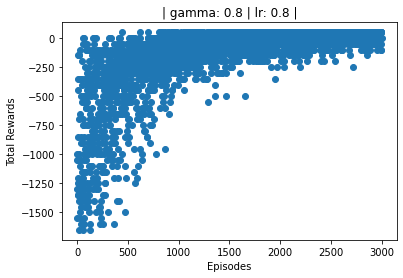

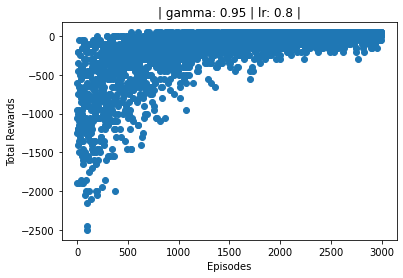

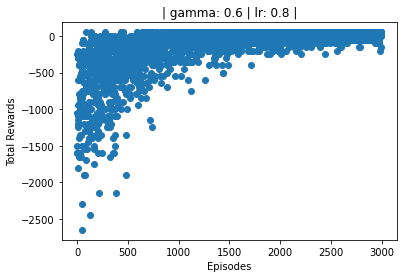

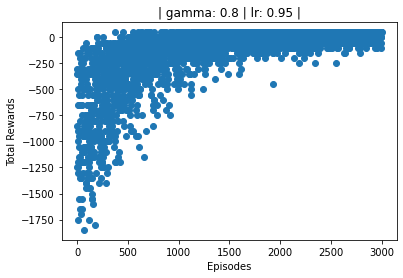

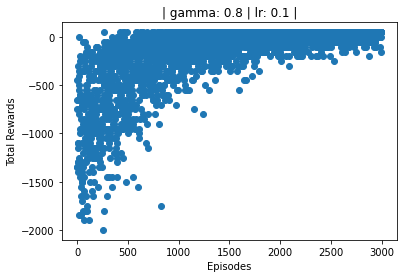

In [ ]:
import time
#  ----------
for (gamma, lr) in [(0.8, 0.8), (0.95, 0.8), (0.6, 0.8), (0.8, 0.95), (0.8, 0.1)]:
  print("| gamma: " + str(gamma) + " | lr: " + str(lr) + " |")
  soln_exist = 0
  start = time.time()
  env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=gamma, lr=lr)
  end = time.time()

  print("time to train: {}, average reward: {}".format(end-start, sum(rewards)/len(rewards)))
  soln_exist = travel_path(env, Q)

  while soln_exist == 0:
    env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=gamma, lr=lr)
    soln_exist = travel_path(env, Q)

  rewards = np.array(rewards)

  plt.figure()
  plt.scatter(range(len(rewards)), rewards)
  plt.ylabel('Total Rewards')
  plt.xlabel('Episodes')
  plt.title("| gamma: " + str(gamma) + " | lr: " + str(lr) + " |")

### Use N = 6, M = 10 and learn a models with (gamma, lr) = (0.8, 0.8)
After learning the model, display a path traveled from source to goal.

In [22]:
#  ----------
env, Q, rewards = init_env_and_learn(N=6, M=10, gamma=0.8, lr=0.8)
soln_exist = travel_path(env, Q)
# -------------------------------

 Action:  Right  | Step No:  1  
[['S' 'C' 'F' 'H' 'F' 'H']
 ['H' 'F' 'F' 'F' 'F' 'H']
 ['H' 'H' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'G']]

 Action:  Right  | Step No:  2  
[['S' 'F' 'C' 'H' 'F' 'H']
 ['H' 'F' 'F' 'F' 'F' 'H']
 ['H' 'H' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'G']]

 Action:  Down  | Step No:  3  
[['S' 'F' 'F' 'H' 'F' 'H']
 ['H' 'F' 'C' 'F' 'F' 'H']
 ['H' 'H' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'G']]

 Action:  Right  | Step No:  4  
[['S' 'F' 'F' 'H' 'F' 'H']
 ['H' 'F' 'F' 'C' 'F' 'H']
 ['H' 'H' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'G']]

 Action:  Right  | Step No:  5  
[['S' 'F' 'F' 'H' 'F' 'H']
 ['H' 'F' 'F' 'F' 'C' 'H']
 ['H' 'H' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H']
 ['F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'G']]

 Action:  Down  

Reference:[BCS_Workshop_Apr_20](https://github.com/bcs-iitk/BCS_Workshop_Apr_20)